In [2]:
import uproot
from glob import glob
import json 
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

In [ ]:
with open('pion_train.json', 'w') as f:
    json.dump(pion_files[:350], f)
with open('pion_val.json', 'w') as f:
    json.dump(pion_files[350:400], f)
with open('pion_test.json', 'w') as f:
    json.dump(pion_files[400:], f)

In [ ]:
import math 
def delta_phi(phi1, phi2):
    return (phi1 - phi2 + math.pi) % (2*math.pi) - math.pi

def apply_cuts(arrays):
    df = pd.DataFrame(arrays)

    ### Single-track, multi-cluster 
    df = df[(df.nTrack == 1)]
    dR_pass = []
    deltaR_list = []
    for row in df.index:
        try:
            deltaR = np.sqrt((df['cluster_Eta'][row].astype('float') - df['trackEta'][row].astype('float'))**2 + 
                               delta_phi(df['cluster_Phi'][row].astype('float'), df['trackPhi'][row].astype('float'))**2)
        except:
            deltaR = np.array(999)
        deltaR_list.append(deltaR)
        dR_pass.append(deltaR < 1.2)
    df["deltaR"] = deltaR_list
    df["dR_pass"] = dR_pass
    df["event_number"] = df.index
    df.reset_index(inplace=True)
    indices_pass = [] 
    for row in df.index: # kill all events with no clusters passing the delta R cut; deal with individual clusters at the training stage
        if len(df['trackPt'][row]) > 1:
            continue
        elif df.dR_pass[row].sum() > 0:
            indices_pass.append(row)
    df = df.iloc[indices_pass]
    df = df[(df.trackPt < 10**5)] # Track pT cut 
    return df

In [ ]:
# use a pared-down list of variables 
variables = ['cluster_cell_E', 'cluster_cell_ID',
             'trackPt','trackD0','trackZ0',
             'trackEta_EMB2','trackPhi_EMB2',
             'trackEta_EME2','trackPhi_EME2',
             'trackEta','trackPhi',
             'nCluster','nTrack','truthPartE', 'truthPartPt',
             'cluster_ENG_CALIB_TOT','cluster_E','cluster_Eta','cluster_Phi',
             'cluster_EM_PROBABILITY','cluster_E_LCCalib','cluster_HAD_WEIGHT']

In [ ]:
for file in tqdm(pi0_files):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    folder = os.path.join("/".join(prefix), 
                          "onetrack_multicluster", 
                          "pi0_files")
    os.makedirs(folder, exist_ok=True)
    npy_filename = os.path.join(folder, str(number)+".npy")
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    a_cuts = df.to_dict('list')
    np.save(npy_filename, a_cuts) 

In [ ]:
for file in tqdm(pion_files):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    folder = os.path.join("/".join(prefix), 
                          "onetrack_multicluster", 
                          "pion_files")
    os.makedirs(folder, exist_ok=True)
    npy_filename = os.path.join(folder, str(number)+".npy")
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    a_cuts = df.to_dict('list')
    np.save(npy_filename, a_cuts) 

### Testing

In [73]:
a = uproot.open(pi0_files[0])["EventTree"].arrays(
    # variables, 
    library = "np")
a.keys()

dict_keys(['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackEta_PreSamplerB', 'trackPhi_PreS

In [74]:
df = pd.DataFrame(a)
# df = df[(df.nTrack == 1)]

In [21]:
np.mean(df.cluster_nCells.explode())

87.5297559286827

In [ ]:
for row in df.index:
    np.sqrt((df['cluster_Eta'][row].astype('float') - 
             df['trackEta'][row].astype('float'))**2 + 
                           delta_phi(df['cluster_Phi'][row].astype('float'), 
                                     df['trackPhi'][row].astype('float'))**2)

In [11]:
df["truthPartE"] = df.truthPartE.explode()
df["trackPt"] = df.trackPt.explode()
df["trackChiSquared"] = df.trackChiSquared.explode()

In [108]:
dfs = []
for file in tqdm(pion_files[:50]):
    a = uproot.open(file)["EventTree"].arrays(library = "np")
    dff = pd.DataFrame(a)
    dff["nCluster"] = dff.nCluster.explode()
    dff["pion_eta"] = dff.truthPartEta.explode()
    dfs.append(dff)
df_pion = pd.concat(dfs)

100%|██████████| 50/50 [04:30<00:00,  5.42s/it]


In [109]:
dfs = []
for file in tqdm(pi0_files[:50]):
    a = uproot.open(file)["EventTree"].arrays(library = "np")
    dff = pd.DataFrame(a)
    dff["nCluster"] = dff.nCluster.explode()
    pion_eta = []
    for row in dff.index:
        pion_eta.append(dff.truthPartEta[row][0])
    dff["pion_eta"] = np.array(pion_eta)
    dfs.append(dff)
df_pi0 = pd.concat(dfs)

100%|██████████| 50/50 [04:03<00:00,  4.87s/it]


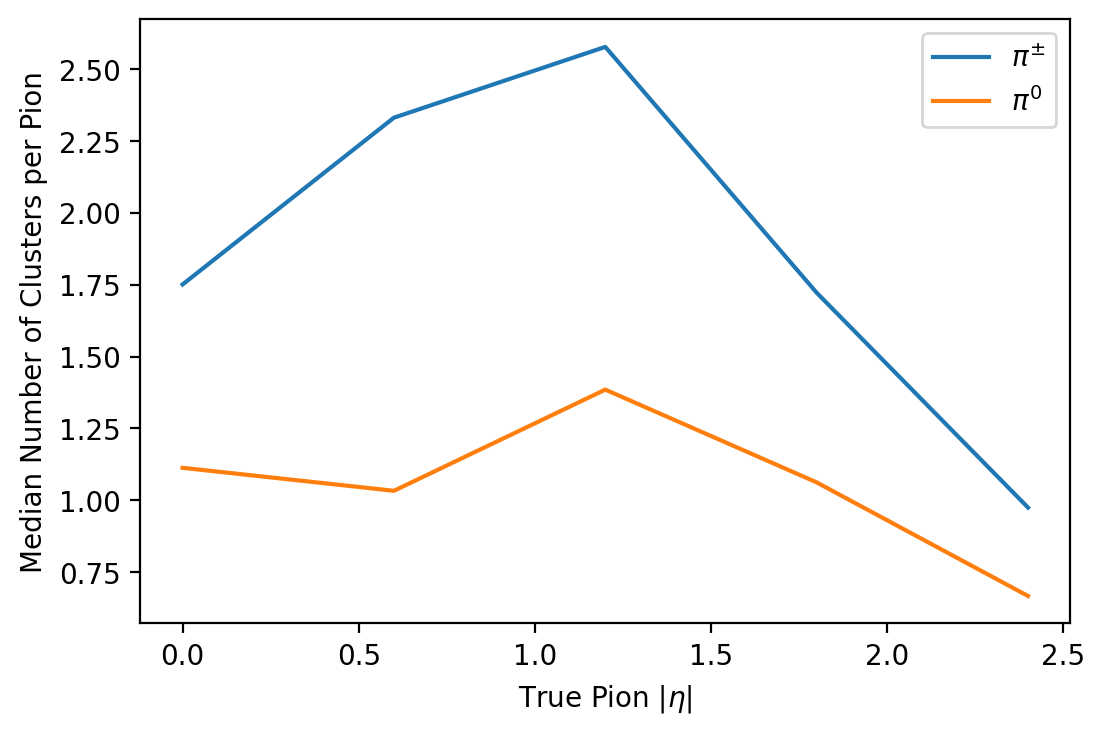

In [122]:
from scipy import stats 
binned_stats_pion = stats.binned_statistic(np.array(np.abs(df_pion.pion_eta), dtype=float), 
                                           np.array(df_pion.nCluster, dtype=float), 
                                           statistic='mean', bins=5)

binned_stats_pi0 = stats.binned_statistic(np.array(np.abs(df_pi0.pion_eta), dtype=float), 
                                           np.array(df_pi0.nCluster, dtype=float), 
                                           statistic='mean', bins=5)

plt.figure(dpi=200)
plt.plot(binned_stats_pion.bin_edges[:-1], binned_stats_pion.statistic, label=r"$\pi^{\pm}$")
plt.plot(binned_stats_pi0.bin_edges[:-1], binned_stats_pi0.statistic, label=r"$\pi^{0}$")
plt.xlabel(r"True Pion $|\eta|$");
plt.ylabel("Median Number of Clusters per Pion");
plt.legend();

In [13]:
df = pd.DataFrame(a)

#     ### Single-track, multi-cluster 
df = df[(df.nTrack == 1)]
#     dR_pass = []
#     deltaR_list = []
#     for row in df.index:
#         try:
#             deltaR = np.sqrt((df['cluster_Eta'][row].astype('float') - df['trackEta'][row].astype('float'))**2 + 
#                                delta_phi(df['cluster_Phi'][row].astype('float'), df['trackPhi'][row].astype('float'))**2)
#         except:
#             deltaR = np.array(999)
#         deltaR_list.append(deltaR)
#         dR_pass.append(deltaR < 1.2)
#     df["deltaR"] = deltaR_list
#     df["dR_pass"] = dR_pass
#     df["event_number"] = df.index
#     df.reset_index(inplace=True)
#     indices_pass = [] 
#     for row in df.index: # kill all events with no clusters passing the delta R cut; deal with individual clusters at the training stage
#         if len(df['trackPt'][row]) > 1:
#             continue
#         elif df.dR_pass[row].sum() > 0:
#             indices_pass.append(row)
#     df = df.iloc[indices_pass]
#     df = df[(df.trackPt < 10**5)] # Track pT cut 
#     return df

In [ ]:
for file in tqdm(pion_files[:10]):
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = pd.DataFrame(a)
    if len(df[(df.truthPartE < 0.3) & (df.nTrack == 1)]) != 0:
        print("Match found!")
# print(df.truthPartE.min())

In [ ]:
df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files[400:])])
df.reset_index(inplace=True)
print(len(df[(df.truthPartE < 0.3) & (df.nTrack == 1)]))
print(df[(df.truthPartE < 0.3) & (df.nTrack == 1)].truthPartE)

In [ ]:
df[(df.truthPartE < 0.3) & (df.nTrack == 1)].truthPartE

In [ ]:
df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files[300:400])])
df.reset_index(inplace=True)
print(len(df[(df.truthPartE < 0.3) & (df.nTrack == 1)]))
print(df[(df.truthPartE < 0.3) & (df.nTrack == 1)].truthPartE)

In [ ]:
df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files[:300])])
df.reset_index(inplace=True)
print(len(df[(df.truthPartE < 0.3) & (df.nTrack == 1)]))
print(df[(df.truthPartE < 0.3) & (df.nTrack == 1)].truthPartE)

In [ ]:
df[(df.truthPartE < 0.25)].nTrack.value_counts()

In [ ]:
df[(df.truthPartE < 0.25) & (df.nTrack == 1)].truthPartE

In [ ]:
df_test = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files[400:])])
df_test.reset_index(inplace=True)
print(len(df_test[(df_test.truthPartE < 0.25) & (df_test.nTrack == 1)]))
print(df_test[(df_test.truthPartE < 0.25) & (df_test.nTrack == 1)].truthPartE)

In [ ]:
df_all = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df_all.reset_index(inplace=True)
print(len(df_all[(df_all.truthPartE < 0.25) & (df_all.nTrack == 1)]))
print(df_all[(df_all.truthPartE < 0.25) & (df_all.nTrack == 1)].truthPartE)

In [ ]:
len(df[(df.truthPartE < 0.3) & (df.nTrack == 1)])

In [ ]:
100*6/len(df)

In [ ]:
df[(df.truthPartE < 0.3) & (df.nTrack == 1)].truthPartE

In [ ]:
df_2 = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df_2.reset_index(inplace=True)

In [ ]:
df_2[(df_2.truthPartE < 0.3) & (df_2.nTrack == 1)].truthPartE

In [ ]:
a = uproot.open(pion_files[0])["EventTree"].arrays(variables, library = "np")
df = pd.DataFrame(a)
df = df[(df.nTrack == 1)]
print(df.truthPartE.min())

In [ ]:
df.truthPartE.min()

In [ ]:
df = apply_cuts(a)

In [ ]:
all_drs = []
dfs = []
for file in tqdm(pion_files[:10]):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    folder = os.path.join("/".join(prefix), "onetrack_multicluster", "pion_files")
    os.makedirs(folder, exist_ok=True)
    npy_filename = os.path.join(folder, str(number)+".npy")
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    list = df.deltaR.to_numpy().flatten()
    drs = np.concatenate(list, axis=0)
    all_drs.append(drs)
    dfs.append(df)
    
import matplotlib.pyplot as plt
all_drs = np.concatenate(all_drs, axis=0)

plt.figure(dpi=200)
plt.hist(all_drs, bins=np.linspace(0.5,1.5,30));
plt.xlabel(r"$\Delta R$(cluster,track)")

plt.figure(dpi=200)
plt.hist(all_drs, bins=np.linspace(0.5,1.5,30));
plt.yscale("log")
plt.xlabel(r"$\Delta R$(cluster,track)")

In [ ]:
df = pd.concat([df for df in dfs])

In [ ]:
plt.figure(dpi=150)
plt.hist(np.concatenate(df.trackPt.to_numpy().flatten(), axis=0), bins=10);
plt.xlabel(r"Track $p_T$")
plt.yscale("log")

### Scaling

In [ ]:
cluster_cell_e = []
cluster_e = []
cluster_eta = []
cluster_phi = []
track_pt = []
track_z0 = []
track_eta = []
track_phi = []
truth_part_e = []

n_files = 10

for file in tqdm(pion_files[:n_files]):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    track_pt.append(df.trackPt.explode())
    track_z0.append(df.trackZ0)
    track_eta.append(df.trackEta)
    track_phi.append(df.trackPhi)
    truth_part_e.append(df.truthPartE.explode())
    for i in range(len(df)): 
        for cluster in range(df.nCluster.iloc[i]):
            cluster_cell_e.append(np.array(np.log10(df.cluster_cell_E.iloc[i][cluster])))
            cluster_e.append(np.array(np.log10(df.cluster_E.iloc[i][cluster])))
            cluster_eta.append(np.array(df.cluster_Eta.iloc[i][cluster]))
            cluster_phi.append(np.array(df.cluster_Phi.iloc[i][cluster]))

print("Track pT | mean: {} | std: {}".format(np.mean([np.log10(x) for x in np.concatenate(track_pt)]), np.std([np.log10(x) for x in np.concatenate(track_pt)])))
print("Track z0 | mean: {} | std: {}".format(np.mean(np.concatenate(track_z0)), np.std(np.concatenate(track_z0))))
print("Track eta | mean: {} | std: {}".format(np.mean(np.concatenate(track_eta)), np.std(np.concatenate(track_eta))))
print("Track phi | mean: {} | std: {}".format(np.mean(np.concatenate(track_phi)), np.std(np.concatenate(track_phi))))

print("Truth particle E | mean: {} | std: {}".format(np.mean([np.log10(x) for x in np.concatenate(truth_part_e)]), np.std([np.log10(x) for x in np.concatenate(truth_part_e)])))

print("Cluster cell e")
print(np.mean(np.concatenate(cluster_cell_e)))
print(np.std(np.concatenate(cluster_cell_e)))
        
print("Cluster e")
print(np.mean(cluster_e))
print(np.std(cluster_e))

print("Cluster eta")
print(np.mean(cluster_eta))
print(np.std(cluster_eta))

print("Cluster phi")
print(np.mean(cluster_phi))
print(np.std(cluster_phi))

In [ ]:
scales = {
    'track_pt_mean': 1.633278727,
    'track_pt_std': 0.8481947183,
    'track_z0_mean': 0.08022017,
    'track_z0_std': 42.53320004,    
    'track_eta_mean': -0.00563187,
    'track_eta_std': 1.35242735,    
    'track_phi_mean': 0.00206431,
    'track_phi_std': 1.81240248,   
    'truth_part_e_mean': 1.92469358, 
    'truth_part_e_std': 0.8289864, 
    'cluster_cell_e_mean': -1.0121697,
    'cluster_cell_e_std': 0.818357, 
    'cluster_e_mean': 0.89923394,
    'cluster_e_std': 1.0585934,
    'cluster_eta_mean': 0.016195267,
    'cluster_eta_std': 1.3400925,
    'cluster_phi_mean': 0.0050816955,
    'cluster_phi_std': 1.8100655,
         }

In [ ]:
cell_geo_file = "/clusterfs/ml4hep/mpettee/ml4pions/data/cell_geo.root"
df = uproot.open(cell_geo_file)['CellGeo'].arrays(library='pd')
df.reset_index(inplace=True)
vars = ['cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi']
for var in vars: 
    print(var)
    print(np.mean(df[var]))
    print(np.std(df[var]))

In [ ]:
scales.update({
    'cell_geo_sampling_mean': 3.8827391420197177,
    'cell_geo_sampling_std': 3.9588233603576204,
    'cell_geo_eta_mean': 0.0005979097,
    'cell_geo_eta_std': 1.4709069,
    'cell_geo_phi_mean': -2.8938382e-05,
    'cell_geo_phi_std': 1.813651,
    'cell_geo_rPerp_mean': 1478.9285,
    'cell_geo_rPerp_std': 434.60815,
    'cell_geo_deta_mean': 0.026611786,
    'cell_geo_deta_std': 0.03396141,
    'cell_geo_dphi_mean': 0.068693615,
    'cell_geo_dphi_std': 0.038586758,  
})

In [ ]:
scales

In [ ]:
# Node features: 
# {
# np.log10(cluster_cell_E), 
# cell_geo_sampling, 
# cell_geo_eta, 
# cell_geo_phi, 
# cell_geo_rPerp, 
# cell_geo_deta, 
# cell_geo_dphi
#}

In [ ]:
node_means = [
    scales["cluster_cell_e_mean"], 
    scales["cell_geo_sampling_mean"],
    scales["cell_geo_eta_mean"],
    scales["cell_geo_phi_mean"],
    scales["cell_geo_rPerp_mean"],
    scales["cell_geo_deta_mean"],
    scales["cell_geo_dphi_mean"],
] 

node_stds = [
    scales["cluster_cell_e_std"], 
    scales["cell_geo_sampling_std"],
    scales["cell_geo_eta_std"],
    scales["cell_geo_phi_std"],
    scales["cell_geo_rPerp_std"],
    scales["cell_geo_deta_std"],
    scales["cell_geo_dphi_std"],
] 

In [ ]:
node_means

In [ ]:
node_stds